# Outlier Detection of 4 Digit MWC 4 Players using Tournament Scores

---

author: polytetralhx & HowToProgramming

---

## Objective

This analysis aims for the main goal of the 4dm4 analysis, which is to find the robust model to **Skillban** the outperformers (Derankers) in rank-restricted tournament with the sample data being **4 digit mwc 4 scores** from official Multiplayer Links. We have defined the **Derankers** as follows

Derankers (n.) *a player who outperforms other players in the rank-restricted tournament.*

"Outperform" is, at a glance, subjective to define. The question arises that what is the criteria of a player to be an *Outperformer* or a *Deranker*. Of course, we use statistics to reduce the "subjectiveness" of the definitions.

## Methodology

Recapped from previous analyses, we have analyzed the follows:
- Dimensionality Reduction Techniques and Various Outlier Detection Models.
    - Note : This attempt failed because how unexplainable the model is
- Regression Analysis to find the Progression of the Scores through the rounds.
- Survival Analysis & Logistic Regression to find the effect of qualifiers scores on the bracket elimination stages.
- Experimentation with Box-Cox Transformation to make our score data Normally Distributed (failed however sadge).

This Notebook is the attempt of applying **Local Outlier Factor (LOF)** to detect the outliers from the model. There will be a twist of Index abusing the **Local Outlier Factor** model using the different distance metric to satisfy our objections.

### Local Outlier Factor

**Local Outlier Factor** is an **Outlier Detection Model** which uses the **Local Reachability Density** to detect the outliers. Namely, the **Data Point** with low Local Density will be considered outliers. Before we go into the details, it would be a good approach to simplify some complicate definitions down.

#### Definitions

**Reachability Distance** : The maximum of distance the point A needs to reach to point B and the distance from point B to their k-closest neighbors. The visualization can be that given B is a friend with k neighbors, how long (or how much distance) would it take to befriend with A.

**Local Reachability Density** : In a nutshell, assuming A has k-nearest neighbors, the Local Reachability Density is how tiring it is for A to communicate with their neighbors face-to-face.

**Local Outlier Factor** : After these two definitions, A compare their extrovertness with neighbors and result in how introvert A is. If A is too introverted (LOF is high) -> A is an outlier.

Well, I hope you guys find this "oversimplification" understandable. However, as Index has mentioned, he abused this introvertness meter with a new distance metric.

### Local Outlier Factor with Elastic Euclidean Distance

Normally, **Local Outlier Factor** model uses **Euclidean Distance** as a main distance metric, namely for defining **Local Reachability Density** and **Local Outlier Factor**. This approach will detect the data points which has less density. This comes with the problem when they detect the point near the center and they don't use "score" as a consideration that much, so we implemented the **Elastic Net** into the Euclidean Distance Metric and call it **Elastic Euclidean Distance**

**Elastic Euclidean Distance** is defined as follows :
```python
def elastic_euclidean(A, B):
    return euclidean(A, B) * lmbda1 + sum(A ** 2) * lmbda2 + sum(abs(A)) * lmbda3
```

where `lmbda1`, `lmbda2` and `lmbda3` are **Hyperparameters** (they are user-defined)

- sum(A ** 2) : is called a "Ridge Factor", it is a soft metric to add up more scores to the anomaly
- sum(abs(A)) : is called a "Lasso Factor", it is a hard metric to add up more scores to the anomaly

TODO : Find the difference between two factors

However, in this approach, you need to standardize the data (classic (x - mu) / sigma) before fitting the model to prevent the value inflation.

## Code Explanation

### Import Necessary Libraries

Here, we use `pandas` for DataFrame managements, `matplotlib.pyplot` for further visualization and `numpy` for finding `mean` and `std`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Import Necessary Utilities

These are utilities that are available on the original repository. We will use
- **LOF** for Local Outlier Factor Model
- **nan_euclidean** and **elastic_nan_euclidean** for Local Outlier Factor Metric
- **get_table_players** for transforming data which is gathered from `sqlite3 .db`
- **Dataset** to deal with `sqlite3 .db` in general

In [2]:
from utils.lof import LOF
from utils.metrics import nan_euclidean, elastic_nan_euclidean
from utils import get_table_players

In [3]:
from utils import Dataset

### Defining the Elastic Euclidean Distance

Here, we use `lmbda1` = 1; `lmbda2` = `lmbda3` = 0.25 so the formula of our distance metric is

euclidean(A, B) * 1 + sum(A ** 2) * 0.25 + sum(abs(A)) * 0.25

In [4]:
euclidean_regularized = elastic_nan_euclidean(1, 0.25, 0.25)

### Initializing the Dataset and Querying the data

We use `4dm4.db` for our current study, and the logit transformation of scores from all round which has the category `LN`, `RC` and `HB`

In [5]:
_4dm4_impute = Dataset('4dm4.db')

In [6]:
_4dm4_data = _4dm4_impute.select('scores', columns=['player_name', 'round', 'beatmap_type', 'beatmap_tag', 'score_logit'], where={
    'beatmap_type': ['LN', 'RC', 'HB'],
})

### Data Transformation

We then transform the Queried Data to the table of players and maps

In [7]:
_4dm4_table = get_table_players(_4dm4_data)

### Standardizing the Data

As mentioned in [this part](#local-outlier-factor-with-elastic-euclidean-distance), we need to standardize data in order to use the model with this metric. So we define `standardized_4dm` then standardize depending on individual maps and ignoring the `NaN` data.

In [8]:
standardized_4dm = pd.DataFrame(index=_4dm4_table.index)

In [9]:
for col in _4dm4_table.columns:
    mu = np.nanmean(_4dm4_table[col]); sigma = np.nanstd(_4dm4_table[col], ddof=1)
    standardized_4dm[col] = _4dm4_table[col].apply(lambda x: (x - mu) / sigma)

In [10]:
standardized_4dm.head()

,Q_RC_1,Q_RC_2,Q_LN_1,Q_HB_1,RO32_RC_1,RO32_RC_4,RO32_RC_5,RO32_LN_3,RO32_HB_1,RO16_RC_1,...,GF_RC_7,GF_LN_2,GF_LN_3,GF_LN_4,GF_HB_1,GF_HB_2,GF_HB_3,SF_RC_2,SF_HB_3,GF_RC_3
drag_,-1.271311,-0.888601,-0.288915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JPBenedictGame,-0.133422,0.052810,-0.519245,-0.407806,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iVALORUS,-2.538866,-1.609407,-2.138151,-1.485972,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL5,0.293309,-0.947536,0.162731,0.073857,-1.536132,-1.589838,-0.170574,-0.071868,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Tebo-,0.427527,-0.009594,0.551290,-0.779546,0.079211,1.000453,0.577630,0.090251,0.900541,0.542193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Implementing the Local Outlier Factor Model

We then declare the model with n_neighbors (k) = 5 and use our defined Elastic Euclidean Distance as a Metric

In [11]:
lof_euclid = LOF(5, euclidean_regularized)

We then train and predict the Local Outlier Factor of each player, stored in `lof_values`

In [12]:
lof_values = lof_euclid.fit_predict(standardized_4dm.values)

Then we map those in a `DataFrame` in order to assign players their Local Outlier Factors

In [13]:
lof_4dm = pd.DataFrame(index=standardized_4dm.index)

lof_4dm['lof'] = lof_values

This is the outlier score of **shokoha**, an outstanding player in 4 digit MWC 4.

In [14]:
lof_4dm.loc['shokoha']

lof    12.094472
Name: shokoha, dtype: float64

These are top 16 of the players who have the highest outlier scores.

In [15]:
lof_4dm.sort_values(by='lof', ascending=False).head(16)

,lof
shokoha,12.094472
[LS]Byte,9.599609
Ricizus,9.565402
RaGe Radical,7.367328
MisteurFR,6.218913
Lazereed,5.357931
[LS]Taylor,4.865639
Gray Hardrock,4.642799
henryalexbr,4.533962
Micleak,4.485532


Note that there still be an **Underperforming Players** left in this procedure. They will be filtered out in the further study.

We then plot the Distribution and find 1-3th Quartiles and 97.5th Percentile of the Local Outlier Factor

(array([112.,  56.,  19.,   7.,   1.,   1.,   1.,   2.,   0.,   1.]),
 array([ 0.25634921,  1.44016147,  2.62397372,  3.80778597,  4.99159823,
         6.17541048,  7.35922273,  8.54303499,  9.72684724, 10.91065949,
        12.09447175]),
 <BarContainer object of 10 artists>)

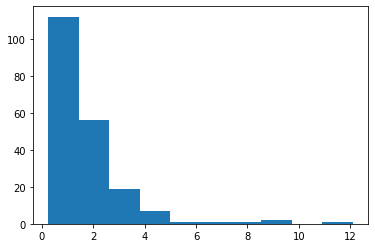

In [16]:
plt.hist(lof_4dm['lof'].values)

In [21]:
print("25% of the LOF is", lof_4dm['lof'].quantile(0.25))
print("Median of the LOF is", lof_4dm['lof'].quantile(0.50))
print("75% of the LOF is", lof_4dm['lof'].quantile(0.75))
print("97.5% of the LOF is", lof_4dm['lof'].quantile(0.975))

25% of the LOF is 0.9017889364625085
Median of the LOF is 1.3306853498557236
75% of the LOF is 2.1097061854631334
97.5% of the LOF is 5.379455479502165


## Discussion

As I've discussed with poly, the model is borderline interpretable (There is a way to explain the process of skillbanning and how those numbers come from) to the players. To clarify that the model works, we need the human contribution on handpicking outliers and we can try this model with various tournaments, for example, Violet Mania Tournament organized by Saemitsu.

This model is still undone and lack of ability to visualize however. The left outlier (underperformers) have not been filtered out and we need to work on how to visualize where the outliers are in a few dimensions. This requires dimensionality reduction (to be precise, PCA) and we need to sacrifice some "interpretability" if we demand the images and position of the outliers.

As we go on... well, feel free to give us ideas via Discord, and as poly said, feel free to tell us if these analyses will benefit your tournament organization.